# Thai Text Spam Classifier based on SVM


Given simple dataset that collect text with labelled

The model workflow is first get text, then token word by pythainlp library after that use sklearn countvertorize to extract feature.

This notebook consist of following section

### 1. EDA
look data shape, type, null value and importantly check imbalance of dataset.

### 2. Training
Perform training and GridSearchCV for best parameter

### 3. Testing
Useing accuracy as a measurement metric




*Last update: 26 Mar 2021, Part J.*


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
traindata = pd.read_csv('classifier_data/training_set.csv')
testdata = pd.read_csv('classifier_data/testing_set.csv')

## EDA

In [3]:
traindata.shape

(2105, 3)

In [4]:
testdata.shape

(527, 2)

In [5]:
traindata.describe()

,bad
count,2105.000000
mean,0.495962
std,0.500102
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
traindata.head()

,PromotionId,description,bad
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0


In [7]:
testdata.head()

,PromotionId,description
0,1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แ...
1,1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด 10 บาททันที สำหรับลูกค้าในการซื้อแก้วแรก
2,1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,NaN
3,1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,LINEMAN บริการส่งเค้กถึงมือท่าน
4,1NWLC0j3XRIwoXpTNXFkZVah0bnasd,2 วันสุดท้ายของเดือนนี้\n\n\n30-31 สค 61


In [8]:
traindata.dtypes

PromotionId    object
description    object
bad             int64
dtype: object

In [9]:
#  check null
traindata.isnull().sum()

## null value contain 1/4 of dataset, null also implied bad promotion so just leave as it is

PromotionId      0
description    570
bad              0
dtype: int64

In [10]:
# Check Imbalance data !!! this is important
traindata['bad'].value_counts()

## look like dataset is balance that's cool!

0    1061
1    1044
Name: bad, dtype: int64

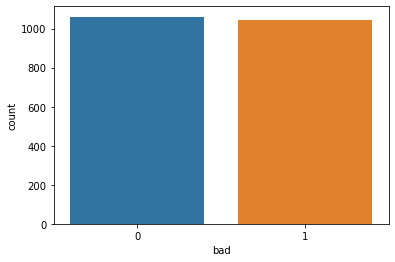

In [11]:
ax = sns.countplot(x="bad", data=traindata)

## Training

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from pythainlp.tokenize import word_tokenize

In [13]:
def wordToken(text):
    return word_tokenize(text, engine="newmm")

In [14]:
# split data for train and test

from sklearn.model_selection import train_test_split
train, test = train_test_split(traindata, test_size =.2, random_state=1, stratify=traindata.bad)

In [15]:
train.shape

(1684, 3)

In [16]:
# Clean data: strip new line, remove irrelevant symbol

train['feature'] = train.description

train['feature'] = train['feature'].replace('\n',' ', regex=True)
train['feature'] = train['feature'].replace('[^\w\s#@/:%.,_-]', '')

train.head()

,PromotionId,description,bad,feature
1205,1NWLBO3bwOUOB88Sr3GAo31nbptCWW,โปรโมชั่นเปิดร้าน วันนี้วันเดียว\n\n\n\n18 08 ...,0,โปรโมชั่นเปิดร้าน วันนี้วันเดียว 18 08 18 ...
73,1NWLBqv7ODub2WEc1kjDD4h5DEdal1,สมาชิก,0,สมาชิก
102,1NWLBqu73sYzuFXL4DJsq4gw6cxU10,โปรโมชั่น “Live Canadian Lobster”กับ 3 เมนูสุด...,0,โปรโมชั่น “Live Canadian Lobster”กับ 3 เมนูสุด...
659,1NWLCcUaQzZ0eeDpZ6Y68wpjSaynFg,เมนูเซ็ต ราคาพิเศษ พร้อมบริการส่งถึงที่,0,เมนูเซ็ต ราคาพิเศษ พร้อมบริการส่งถึงที่
435,1NWLAZSnaHLTkubTkprNOmdOcQT23l,NaN,1,NaN


In [17]:
# token Thai word

train['feature'] = train['feature'].apply(wordToken)

train.head()

,PromotionId,description,bad,feature
1205,1NWLBO3bwOUOB88Sr3GAo31nbptCWW,โปรโมชั่นเปิดร้าน วันนี้วันเดียว\n\n\n\n18 08 ...,0,"[โปรโมชั่น, เปิดร้าน, , วันนี้, วัน, เดียว, ..."
73,1NWLBqv7ODub2WEc1kjDD4h5DEdal1,สมาชิก,0,[สมาชิก]
102,1NWLBqu73sYzuFXL4DJsq4gw6cxU10,โปรโมชั่น “Live Canadian Lobster”กับ 3 เมนูสุด...,0,"[โปรโมชั่น, , “, Live, , Canadian, , Lobste..."
659,1NWLCcUaQzZ0eeDpZ6Y68wpjSaynFg,เมนูเซ็ต ราคาพิเศษ พร้อมบริการส่งถึงที่,0,"[เมนู, เซ็ต, , ราคา, พิเศษ, , พร้อม, บริการ,..."
435,1NWLAZSnaHLTkubTkprNOmdOcQT23l,NaN,1,[]


In [18]:
cv = CountVectorizer()
features = cv.fit_transform(train.feature.apply(' '.join))
print(cv.get_feature_names())
print(features.toarray())

['00', '000', '001', '011', '0111', '015', '0176182', '0189200', '02', '022470123', '023224407', '0297', '03', '033', '043', '044', '052', '053', '053079', '054', '060', '061', '062', '0625304040', '0631408789', '064', '0649492665', '0649649363', '07', '076', '08', '080', '081', '082', '0820862388', '0828884237', '083', '084', '085', '086', '0866', '087', '0877891112', '0885555950', '089', '0894184489', '09', '090', '0925639939', '094', '0945169795', '095', '0968602285', '0974749900', '0979454242', '098', '099', '10', '100', '1000', '1010', '105', '1080', '109', '11', '110', '1111', '1145780235538933', '115', '119', '12', '120', '1200', '121', '122', '123', '1234', '124', '125', '127', '129', '1299', '13', '1300', '139', '14', '140', '1400', '1423313', '145', '148', '149', '15', '150', '156', '157', '159', '16', '160', '1600', '1650', '168', '169', '17', '170', '1700', '171', '175', '179', '1790', '18', '180', '1800', '1810', '183', '188', '189', '19', '190', '1900', '1920', '195', '19

In [19]:
# Build model in this case SVM

In [20]:
y_train = train['bad']

model = svm.SVC()

model.fit(features, y_train)

SVC()

In [21]:
# test

test['feature'] = test.description
test['feature'] = test['feature'].replace('\n',' ', regex=True)
test['feature'] = test['feature'].replace('[^\w\s#@/:%.,_-]', '')
test['feature'] = test['feature'].apply(wordToken)

y_test = test['bad']
features_test = cv.transform(test.feature.apply(' '.join))

print("Accuracy of the model is:" ,model.score(features_test,y_test))

Accuracy of the model is: 0.7862232779097387


In [22]:
# tuning parameter

tuned_parameter = {'kernel':['linear','rbf'],'gamma':['scale', 'auto'],'C':[1,10,100,1000]}

model = GridSearchCV(svm.SVC(),tuned_parameter)

model.fit(features, y_train)

print(model.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## Testing

In [23]:
test['feature'] = test.description
test['feature'] = test['feature'].replace('\n',' ', regex=True)
test['feature'] = test['feature'].replace('[^\w\s#@/:%.,_-]', '')
test['feature'] = test['feature'].apply(wordToken)

y_test = test['bad']
features_test = cv.transform(test.feature.apply(' '.join))

print("Accuracy of the model is:" ,model.score(features_test,y_test))

Accuracy of the model is: 0.7909738717339667


In [24]:
# predict

testdata['feature'] = testdata.description
testdata['feature'] = testdata['feature'].replace('\n',' ', regex=True)
testdata['feature'] = testdata['feature'].replace('[^\w\s#@/:%.,_-]', '')
testdata['feature'] = testdata['feature'].apply(wordToken).apply(' '.join)

item = 1
print(testdata.feature[item])
item = cv.transform([testdata.feature[item]])
y_predict = model.predict(item)
print(y_predict)

ส่วนลด   10   บาท ทันที   สำหรับ ลูกค้า ใน การ ซื้อ แก้ว แรก
[0]


In [25]:
# predict whole test set and save to csv

# testdata['result'] = np.nan

# for i in range(0, testdata.shape[0]):
#     item = cv.transform([testdata.feature[i]])
#     testdata['result'][i:i+1] = model.predict(item)

# del testdata['feature']
# testdata.to_csv(r'predict-result.csv', index = False)    
# testdata.head()

,PromotionId,description,result
0,1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แ...,0.0
1,1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด 10 บาททันที สำหรับลูกค้าในการซื้อแก้วแรก,0.0
2,1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,NaN,1.0
3,1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,LINEMAN บริการส่งเค้กถึงมือท่าน,1.0
4,1NWLC0j3XRIwoXpTNXFkZVah0bnasd,2 วันสุดท้ายของเดือนนี้\n\n\n30-31 สค 61,0.0


In [26]:
testdata['result'].value_counts()

1.0    302
0.0    225
Name: result, dtype: int64

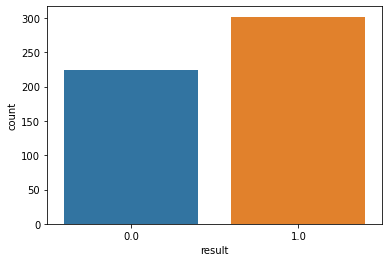

In [27]:
ax_test = sns.countplot(x="result", data=testdata)